In [1]:
# import sys
# !conda install --yes --prefix {sys.prefix} pingouin

In [2]:
import datetime
import numpy as np
import math
import os
import pandas as pd
import pingouin as pg
import re
import seaborn as sns
import json
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg
import sys

if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO
    
from IPython.display import HTML
def View(df):
    css = """<style>
    table { border-collapse: collapse; border: 3px solid #eee; }
    table tr th:first-child { background-color: #eeeeee; color: #333; font-weight: bold }
    table thead th { background-color: #eee; color: #000; }
    tr, th, td { border: 1px solid #ccc; border-width: 1px 0 0 1px; border-collapse: collapse;
    padding: 3px; font-family: monospace; font-size: 10px }</style>
    """
    s  = '<script type="text/Javascript">'
    s += 'var win = window.open("", "Title", "toolbar=no, location=no, directories=no, status=no, menubar=no, scrollbars=yes, resizable=yes, width=780, height=200, top="+(screen.height-400)+", left="+(screen.width-840));'
    s += 'win.document.body.innerHTML = \'' + (df.to_html() + css).replace("\n",'\\') + '\';'
    s += '</script>'
    return(HTML(s+css))    

os.chdir(r'C:\Users\User\GitHub\WebET_Analysis')
print("Current Working directory " , os.getcwd())

Current Working directory  C:\Users\User\GitHub\WebET_Analysis


In [3]:
# from IPython.display import HTML

# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Read Data

In [4]:
data_et = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_et.csv')
data_trial = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_trial.csv')
data_subject = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_subject.csv')

print(pd.DataFrame([[len(data_et)], [len(data_trial)], [len(data_subject)]], 
                   columns=['length'],
                   index=['data_et', 'data_trial', 'data_subject'])
     )

              length
data_et       618566
data_trial     30362
data_subject      84


# Window Size

In [5]:
def addWindowSize(data):
    grouped = data.groupby(["run_id", "subject"])["window_width", "window_height"].max().reset_index()
    grouped.columns = ["run_id", "subject", "window_width_max", "window_height_max"]
    grouped['window_diagonal_max'] = np.sqrt(grouped['window_width_max']**2 + grouped['window_height_max']**2)
    if "window_width_max" in data.columns: data = data.drop(columns=['window_width_max'])
    data = data.merge(grouped, on=['run_id', "subject"], how='left')
    return data

data_trial = addWindowSize(data_trial)
data_trial['window_diagonal'] =  np.sqrt(data_trial['window_width']**2 + data_trial['window_height']**2)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


# Trial Duration

In [6]:
def checkTimeDeviation(data, column1, column2, maxTimeDiffAllowed):
    diff = data[column1] - data['trial_duration_exact']
    longtrials_runID = data.loc[diff[diff > maxTimeDiffAllowed].index, 'run_id']
    longtrials_previousrunID = pd.DataFrame(data.loc[diff[diff > maxTimeDiffAllowed].index-1, 'run_id']) \
        .rename(columns={'run_id':'previous_run_id'})
    longtrials_previousrunID.index = longtrials_runID.index
    compare_runIDs = pd.concat([longtrials_runID, longtrials_previousrunID], axis=1)

    if sum(compare_runIDs['run_id'] == compare_runIDs['previous_run_id']) > 0: 
        print(column1 + ' and ' + column2 + ' show a deviation of ' +
              '>' + str(maxTimeDiffAllowed) + 
              ' ms. Please check on the following indices: \n')
        print(compare_runIDs.loc[(compare_runIDs['run_id'] == compare_runIDs['previous_run_id']), :].index)

    else:
        print('Success! ' + column1 + ' and ' + column2 + ' do not deviate by ' +
              '>' + str(maxTimeDiffAllowed) + 'ms.')
        
def exactTrialDuration(data):
    data["t_startTrial"] = pd.concat([pd.Series([0]), data["time_elapsed"]], ignore_index=True)
    data["trial_duration_exact"] = data.loc[:, ("time_elapsed")] - data.loc[:, ("t_startTrial")]
    data.drop(len(data)-1)
    
    checkTimeDeviation(data, 'rt', 'trial_duration_exact', 50)
    checkTimeDeviation(data, 'trial_duration', 'trial_duration_exact', 50)
    
    return data

data_trial = exactTrialDuration(data_trial)

Success! rt and trial_duration_exact do not deviate by >50ms.
Success! trial_duration and trial_duration_exact do not deviate by >50ms.


# withinTaskIndex

In [7]:
def withinTaskIndex(data): 
    allTrialIndices = []
    for subject in data["run_id"].unique():
        df_subj = data.loc[data['run_id']==subject, :]
        
        for trial_type in df_subj['trial_type'].unique():
            df_trial = df_subj.loc[df_subj['trial_type']==trial_type, :]
                
            for task_nr in df_trial["task_nr"].unique():
                df_thisTask = df_trial.loc[df_trial['task_nr']==task_nr, 
                         ['run_id', 'trial_index']
                    ] \
                    .drop_duplicates() \
                    .reset_index(drop=True)
        
                df_thisTask['withinTaskIndex'] = df_thisTask.index + 1
                allTrialIndices.append(df_thisTask)
    allTrialIndices = pd.concat(allTrialIndices).reset_index(drop=True)
    return allTrialIndices

def addWithinTaskIndex(data):
    newIndices = withinTaskIndex(data)
    if 'withinTaskIndex' in data.columns: data = data.drop(columns=['withinTaskIndex'])
    data = data.merge(newIndices, on = ['run_id', 'trial_index'], how = 'left')
    return data

data_trial = addWithinTaskIndex(data_trial)

# fps

## trial_level

In [8]:
def merge_count_by_index(data, large_data, varName):
    if varName + '_count' in data.columns: data = data.drop(columns=[varName + '_count'])
    grouped = large_data.groupby(["run_id", "trial_index"])[varName].count() \
        .reset_index() \
        .rename(columns={varName: varName + '_count'})
    data = data.merge(grouped, on=["run_id", "trial_index"], how='left')
    return(data)

data_trial = merge_count_by_index(data_trial, data_et, 'x')

data_trial['fps'] = 1000 * data_trial['x_count'] / data_trial['trial_duration_exact']
data_trial['fps'].describe()

count    14488.000000
mean        14.939937
std          7.963906
min          0.072031
25%         10.290713
50%         15.214969
75%         19.294744
max         47.811837
Name: fps, dtype: float64

In [9]:
def spaghettiPlot(data, xVar, yVar, highlightedSubject):
    plt.style.use('seaborn-darkgrid')
    fig, ax = plt.subplots(figsize=(15, 10))

    # Draw Plots
    for subject in data["run_id"].unique():
        ax.plot(data.loc[data['run_id']==subject, xVar], 
                data.loc[data['run_id']==subject, yVar], 
                marker='', color='grey', linewidth=1, alpha=0.4)

    # Highlight Subject 
    ax.plot(data.loc[data['run_id']==highlightedSubject, xVar], 
            data.loc[data['run_id']==highlightedSubject, yVar], 
            marker='', color='orange', linewidth=4, alpha=0.7)

    # Let's annotate the plot
    for subject in data["run_id"].unique():
        if subject != highlightedSubject:
            ax.text(data.loc[data['run_id']==subject, xVar].max()+1, 
                    data.loc[data['run_id']==subject, yVar].tail(1),
                    s=subject, horizontalalignment='left', size='small', color='grey')

        else:
            ax.text(data.loc[data['run_id']==subject, xVar].max()+1, 
                    data.loc[data['run_id']==subject, yVar].tail(1),
                    s=subject, horizontalalignment='left', size='small', color='orange')
    return plt

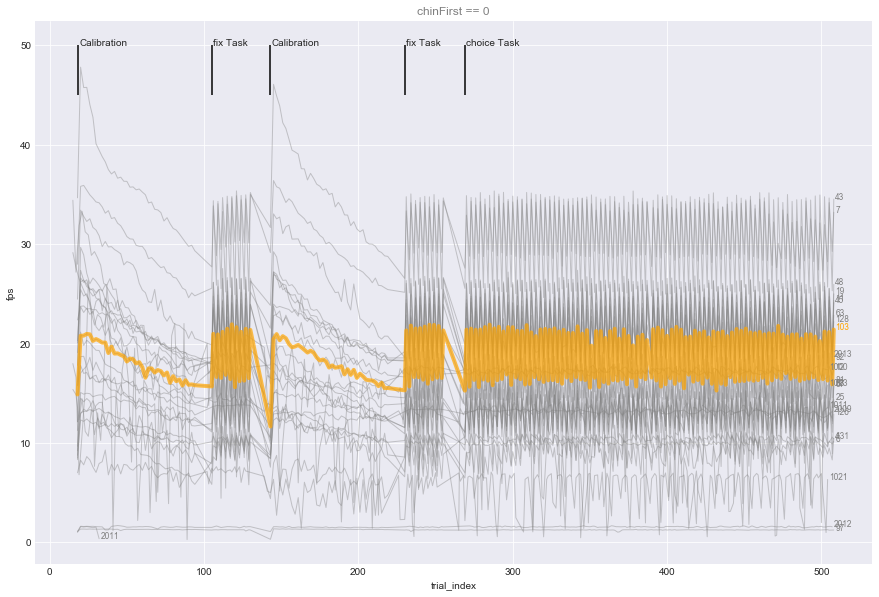

In [10]:
spaghettiPlot(
    data_trial.loc[(data_trial['chinFirst']==0) & pd.notna(data_trial['fps']), :], 
    'trial_index', 'fps', 103
)
plt.title('chinFirst == 0', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('trial_index')
plt.ylabel('fps')
plt.vlines(18, 45, 50, colors='k', linestyles='solid')
plt.text(18+1, 50, s='Calibration')
plt.vlines(105, 45, 50, colors='k', linestyles='solid')
plt.text(105+1, 50, s='fix Task')
plt.vlines(143, 45, 50, colors='k', linestyles='solid')
plt.text(143+1, 50, s='Calibration')
plt.vlines(230, 45, 50, colors='k', linestyles='solid')
plt.text(230+1, 50, s='fix Task')
plt.vlines(269, 45, 50, colors='k', linestyles='solid')
plt.text(269+1, 50, s='choice Task')
plt.show()

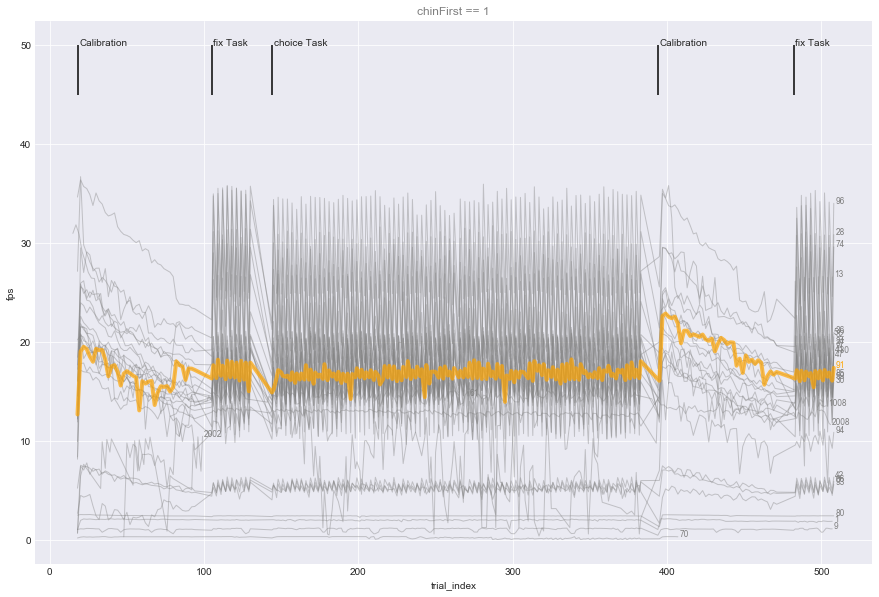

In [11]:
spaghettiPlot(
    data_trial.loc[(data_trial['chinFirst']==1) & pd.notna(data_trial['fps']), :], 
    'trial_index', 'fps', 91
)
plt.title('chinFirst == 1', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('trial_index')
plt.ylabel('fps')
plt.vlines(18, 45, 50, colors='k', linestyles='solid')
plt.text(18+1, 50, s='Calibration')
plt.vlines(105, 45, 50, colors='k', linestyles='solid')
plt.text(105+1, 50, s='fix Task')
plt.vlines(144, 45, 50, colors='k', linestyles='solid')
plt.text(144+1, 50, s='choice Task')
plt.vlines(394, 45, 50, colors='k', linestyles='solid')
plt.text(394+1, 50, s='Calibration')
plt.vlines(482, 45, 50, colors='k', linestyles='solid')
plt.text(482+1, 50, s='fix Task')
plt.show()

## subject-level

C:\Users\User\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\User\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([ 6.,  1.,  4.,  1.,  5.,  2., 10.,  8.,  5.,  7.,  2.,  2.,  0.,
         2.,  1.]),
 array([ 0.28354317,  2.43260903,  4.5816749 ,  6.73074076,  8.87980663,
        11.02887249, 13.17793836, 15.32700422, 17.47607009, 19.62513595,
        21.77420182, 23.92326768, 26.07233355, 28.22139941, 30.37046527,
        32.51953114]),
 <a list of 15 Patch objects>)

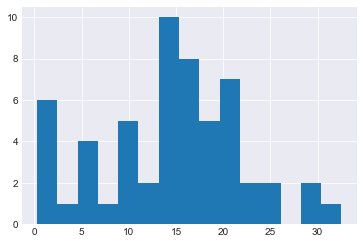

In [12]:
def merge_by_subject(data, large_data, varName):
    if varName in data.columns: data = data.drop(columns=[varName])
    grouped = large_data.groupby(['run_id'])[varName].mean() \
        .reset_index()        
    data = data.merge(grouped, on=['run_id'], how='left')
    return data

data_subject = merge_by_subject(data_subject, data_trial, 'fps')
plt.hist(data_subject['fps'], bins=15)

# data_subject

In [19]:

data_subject['degree'] = data_subject['degree'].replace(
    ['-3.0', '0', '1.5', '2'], np.nan)

data_subject['degree'] = data_subject['degree'].replace({
    'high school': 'highSchool',
    'masters degree': 'grad',
    'Bachelor': 'college',
    'Grad': 'grad'
})

data_subject['degree'] = data_subject['degree'].astype('category') \
    .cat.reorder_categories(['middle', 'highSchool', 'college', 'grad'])
print(data_subject['degree'].unique())

[highSchool, college, NaN, grad, middle]
Categories (4, object): [highSchool, college, grad, middle]


In [14]:
data_subject['webcam_fps'] = np.round(data_subject['webcam_fps'])

In [15]:
data_subject['optionalNote'].unique()

array([nan, 'good survey.',
       'I believe I stayed still  but maybe a moved a little',
       'This study took a long time', 'THE SURVEY WAS ENJOYABLE',
       'I tried the chin rest very briefly  but it was not comfortable and my head did not fit into the green box in this position.'],
      dtype=object)

In [16]:
for col in ['Nationality', 'Employment Status', 'webcam_fps', 'ethnic', 'gender']:
    print(pd.crosstab(index=data_subject[col],
                      columns="count")
         )
    print('\n')

col_0            count
Nationality           
CONSENT REVOKED      1
Germany              1
Greece               3
Hungary              1
Israel               2
Italy                6
Mexico               2
Poland              14
Portugal             3
Serbia               1
South Africa         1
Spain                4
United Kingdom      10
United States        1


col_0                                               count
Employment Status                                        
CONSENT REVOKED                                         1
DATA EXPIRED                                            1
Full-Time                                              25
Not in paid work (e.g. homemaker', 'retired or ...      1
Other                                                   7
Part-Time                                               6
Unemployed (and job seeking)                            9


col_0       count
webcam_fps       
30.0           82
60.0            1


col_0      count
ethnic         

# Export data

In [17]:
data_trial.to_csv("data_jupyter/data_trial.csv", index=False, header=True)
data_subject.to_csv("data_jupyter/data_subject.csv", index=False, header=True)

# Feedback

In [18]:
print('Success! Script ran through')

Success! Script ran through
